In [107]:
import pandas as pd
import pypsa

In [108]:
# Load PyPSA network.
n = pypsa.Network("./base_s_90_elec_lc1.0_Co2L0.01.nc")

INFO:pypsa.io:Imported network base_s_90_elec_lc1.0_Co2L0.01.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


c:\Users\hmtha\anaconda3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x1f484d764b0>,
 <matplotlib.collections.LineCollection at 0x1f484b6c1a0>)

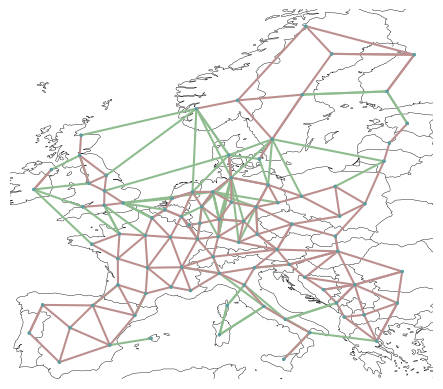

In [109]:
# Map overview of the network (for reference).
n.plot()

In [110]:
# Overview of the networks: buses correspond to nodes, this is a network with 90 nodes across all of Europe.
# n.buses[n.buses.carrier == "AC"] # all nodes.

# Save all nodes with coordinates.
n.buses[n.buses.carrier == "AC"][["x", "y"]].to_csv("./nodes.csv")

In [ ]:
# Prepare cost dataframe.
costs = pd.DataFrame(columns = ["capital_cost", "unit1", "marginal_cost", "unit2"])

# Prepare existing generation dataframe
existing = pd.DataFrame(
    0.0, 
    columns = ["phse", "phsp", "hydroe", "hydrop", "OCGT", "CCGT", "biomass", "nuclear", "ror"], 
    dtype=float,
    index=n.buses[n.buses.carrier == "AC"].index, 
    )
#rename index - surely there's a better way to do this??
existing = existing.reset_index().rename(columns={"Bus":"bus"})
existing.index = existing["bus"]
del existing["bus"]

# Prepare efficiency dataframe
efficiency = pd.DataFrame(
    columns=["efficiency_store", "efficiency_dispatch"],
    index=["phs", "hydro"],
)



In [112]:
# Save all lines including capacities (s_nom), both nodes (bus0, bus1), and the line length and capital cost.
n.lines[n.lines.carrier == "AC"][["s_nom", "bus0", "bus1", "length", "capital_cost"]].to_csv("./lines.csv")
# Compute capital cost per MWkm.
costs.loc["AC_line", "capital_cost"] = n.lines.loc["0", "capital_cost"] / n.lines.loc["0", "length"]
costs.loc["AC_line", "marginal_cost"] = 0.0
costs.loc["AC_line", "unit1"] = "annualised EUR/MWkm"
costs.loc["AC_line", "unit2"] = "-"

# Save all links including capacities (p_nom), both nodes (bus0, bus1), and the capital cost.
n.links[n.links.carrier == "DC"][["p_nom", "bus0", "bus1", "length", "capital_cost"]].to_csv("./links.csv")
# Compute capital cost per MW.
costs.loc["DC_link", "capital_cost"] = n.links.loc["relation/5487095", "capital_cost"] / n.links.loc["relation/5487095", "length"]
costs.loc["DC_link", "marginal_cost"] = 0.0
costs.loc["DC_link", "unit1"] = "annualised EUR/MWkm"
costs.loc["DC_link", "unit2"] = "-"


In [ ]:
# Save all capacity factors (hourly) for solar and wind generators.
fixsolar_generators = n.generators[n.generators.carrier.str.contains("solar$", regex=True)].index
satsolar_generators = n.generators[n.generators.carrier.str.contains("hsat")].index
onwind_generators = n.generators[n.generators.carrier.str.contains("onwind")].index
offwind_generators = n.generators[n.generators.carrier.str.contains("offwind")].index
ror_generators = n.generators[n.generators.carrier == "ror"].index

# CF traces
n.generators_t.p_max_pu.loc[:, fixsolar_generators].round(3).to_csv("./fixsolar_cf.csv")
n.generators_t.p_max_pu.loc[:, satsolar_generators].round(3).to_csv("./satsolar_cf.csv")
n.generators_t.p_max_pu.loc[:, onwind_generators].round(3).to_csv("./onwind_cf.csv")
n.generators_t.p_max_pu.loc[:, offwind_generators].round(3).to_csv("./offwind_cf.csv")
n.generators_t.p_max_pu.loc[:, ror_generators].round(3).to_csv("./ror_cf.csv")

costs.loc["fixsolar", "capital_cost"] = n.generators.loc[fixsolar_generators, "capital_cost"].iloc[0]
costs.loc["fixsolar", "marginal_cost"] = n.generators.loc[fixsolar_generators, "marginal_cost"].iloc[0]
costs.loc["fixsolar", "unit1"] = "annualised EUR/MW"
costs.loc["fixsolar", "unit2"] = "EUR/MWh"

costs.loc["satsolar", "capital_cost"] = n.generators.loc[satsolar_generators, "capital_cost"].iloc[0]
costs.loc["satsolar", "marginal_cost"] = n.generators.loc[satsolar_generators, "marginal_cost"].iloc[0]
costs.loc["satsolar", "unit1"] = "annualised EUR/MW"
costs.loc["satsolar", "unit2"] = "EUR/MWh"

costs.loc["onwind", "capital_cost"] = n.generators.loc[onwind_generators, "capital_cost"].iloc[0]
costs.loc["onwind", "marginal_cost"] = n.generators.loc[onwind_generators, "marginal_cost"].iloc[0]
costs.loc["onwind", "unit1"] = "annualised EUR/MW"
costs.loc["onwind", "unit2"] = "EUR/MWh"

# Capital costs for onshore wind are dependent on the node, so saved separately.
offwind_costs = n.generators.loc[offwind_generators, ["capital_cost", "marginal_cost"]].round(0)
offwind_costs.to_csv("./offwind_costs.csv")

costs.loc["ror", "capital_cost"] = n.generators.loc[ror_generators, "capital_cost"].iloc[0]
costs.loc["ror", "marginal_cost"] = n.generators.loc[ror_generators, "marginal_cost"].iloc[0]
costs.loc["ror", "unit1"] = "annualised EUR/MW"
costs.loc["ror", "unit2"] = "EUR/MWh"

existing.loc[n.generators.loc[ror_generators, "bus"], "ror"] = n.generators.loc[ror_generators, "p_nom"].values


In [114]:
# Save load per node.
n.loads_t.p_set.round(0).to_csv("./load.csv")

In [ ]:
# Save hydropower plants
phs_units = n.storage_units[n.storage_units.carrier == "PHS"].index
hydro_units = n.storage_units[n.storage_units.carrier == "hydro"].index

# n.storage_units.loc[phs_units, ["bus", "p_nom", "capital_cost", "max_hours", "efficiency_dispatch"]].to_csv("./phs_plants.csv")

existing.loc[n.storage_units.loc[phs_units, "bus"], "phsp"] = n.storage_units.loc[phs_units, "p_nom"].values
existing.loc[n.storage_units.loc[phs_units, "bus"], "phsp"] = (n.storage_units.loc[phs_units, "p_nom"]*
                                                               n.storage_units.loc[phs_units, "max_hours"]).values
existing.loc[n.storage_units.loc[hydro_units, "bus"], "hydrop"] = n.storage_units.loc[hydro_units, "p_nom"].values
existing.loc[n.storage_units.loc[hydro_units, "bus"], "hydroe"] = (n.storage_units.loc[hydro_units, "p_nom"]*
                                                                  n.storage_units.loc[hydro_units, "max_hours"]).values

costs.loc["phs", "capital_cost"] = n.storage_units.loc[phs_units, "capital_cost"].iloc[0]
costs.loc["phs", "marginal_cost"] = n.storage_units.loc[phs_units, "marginal_cost"].iloc[0]
costs.loc["phs", "unit1"] = "annualised EUR/MW"
costs.loc["phs", "unit2"] = "EUR/MWh"

costs.loc["hydro", "capital_cost"] = n.storage_units.loc[hydro_units, "capital_cost"].iloc[0]
costs.loc["hydro", "marginal_cost"] = n.storage_units.loc[hydro_units, "marginal_cost"].iloc[0]
costs.loc["hydro", "unit1"] = "annualised EUR/MW"
costs.loc["hydro", "unit2"] = "EUR/MWh"

efficiency.loc["phs", "efficiency_store"] =  n.storage_units.loc[phs_units, "efficiency_store"].iloc[0]
efficiency.loc["phs", "efficiency_dispatch"] =  n.storage_units.loc[phs_units, "efficiency_dispatch"].iloc[0]
efficiency.loc["hydro", "efficiency_store"] =  n.storage_units.loc[hydro_units, "efficiency_store"].iloc[0]
efficiency.loc["hydro", "efficiency_dispatch"] =  n.storage_units.loc[hydro_units, "efficiency_dispatch"].iloc[0]

# Hydropower inflow. (hourly) (MWh)
n.storage_units_t.inflow.round(0).to_csv("./inflow.csv")

In [116]:
# Existing gas capacity, bus, marginal cost, capital cost (for OCGT and CCGT).
ccgt_generators = n.generators.carrier == "CCGT"
ocgt_generators = n.generators.carrier == "OCGT"
nuc_generators = n.generators.carrier == "nuclear"
bio_generators = n.generators.carrier == "biomass"

existing.loc[n.generators.loc[ccgt_generators, "bus"], "CCGT"] = n.generators.loc[ccgt_generators, "p_nom"].values
existing.loc[n.generators.loc[ocgt_generators, "bus"], "OCGT"] = n.generators.loc[ocgt_generators, "p_nom"].values
existing.loc[n.generators.loc[nuc_generators, "bus"], "nuclear"] = n.generators.loc[nuc_generators, "p_nom"].values
existing.loc[n.generators.loc[bio_generators, "bus"], "biomass"] = n.generators.loc[bio_generators, "p_nom"].values


costs.loc["OCGT", "capital_cost"] = n.generators.loc[ocgt_generators, "capital_cost"].iloc[0]
costs.loc["OCGT", "marginal_cost"] = pd.NA
costs.loc["OCGT", "unit1"] = "annualised EUR/MW"
costs.loc["OCGT", "unit2"] = "EUR/MWh"
costs.loc["CCGT", "capital_cost"] = n.generators.loc[ccgt_generators, "capital_cost"].iloc[0]
costs.loc["CCGT", "marginal_cost"] = pd.NA
costs.loc["CCGT", "unit1"] = "annualised EUR/MW"
costs.loc["CCGT", "unit2"] = "EUR/MWh"
costs.loc["nuclear", "capital_cost"] = n.generators.loc[nuc_generators, "capital_cost"].iloc[0]
costs.loc["nuclear", "marginal_cost"] = n.generators.loc[nuc_generators, "marginal_cost"].mean() # very small variance
costs.loc["nuclear", "unit1"] = "annualised EUR/MW"
costs.loc["nuclear", "unit2"] = "EUR/MWh"
costs.loc["biomass", "capital_cost"] = n.generators.loc[bio_generators, "capital_cost"].iloc[0]
costs.loc["biomass", "marginal_cost"] = n.generators.loc[bio_generators, "marginal_cost"].iloc[0]
costs.loc["biomass", "unit1"] = "annualised EUR/MW"
costs.loc["biomass", "unit2"] = "EUR/MWh"



In [117]:
costs.to_csv("./costs.csv")
existing.to_csv("./existing_capacity.csv")

In [ ]:
# with pd.option_context('display.max_rows', None):
#     print(n.generators.loc[n.generators.carrier == "CCGT", 'marginal_cost'])

n.generators.groupby("carrier")["p_nom"].sum()
n.generators.groupby("carrier")["marginal_cost"].describe().round(3)

nuc_generators = n.generators.carrier == "nuclear"
n.generators.loc[nuc_generators, "marginal_cost"].mean()


0.749956